In [1]:
# candle sticks image processing
# simple example from the researchers code https://github.com/pecu/Series2GAF/blob/master/cnn_example/README.md
# GOAL# firstly image process the candle stick chart, high open low close needed I guess?
# How will you classify the shapes? need to measure slope etc and assign a value?
# Get CNN workgin with some level of input data
# How do we then process the pickle file to train a GAN? create the full cycle and then worry about input data and if that is correct.
# then select the model featres, and pattern match the shit out of it.
import numpy as np
from series2gaf import *
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
EURUSD = pd.DataFrame(pd.read_csv(r"C:\Users\edgil\Documents\SysTrade\candlesticks\EURUSDOHLC.csv"))
EURUSD['Datetime'] = pd.to_datetime(EURUSD['Datetime'], format="%d/%m/%Y %H:%M")

testdata = EURUSD[85000:86000]

In [27]:
# add a Rolling regression slope term to fx data
import matplotlib.dates as mpl_dates
import statsmodels.api as sm
model = LinearRegression()
def RegressionCoeff(dependent):
    #yx = pd.concat([pd.DataFrame(depedent[0]),pd.DataFrame(depedent[1])], axis = 1).dropna()
    #yx.columns = ["y", "x"]
    dependent =  pd.DataFrame(dependent)
    # single variable only for reshape of -1,1
    ols = model.fit(np.array(dependent.iloc[:,1]).reshape(-1,1), np.array(dependent.iloc[:,0]))
    #ols = model.fit(np.array(yx["x"]).reshape(-1,1), np.array(yx["y"]))
    return(ols.coef_)

#print(ols.coef_)
    
#testdata.columns
testdata['TimeNumbers'] = testdata['Datetime'].apply(mpl_dates.date2num)
y = testdata["Close"].tail(20)
x = testdata["TimeNumbers"].tail(20)
# axis = 1 merge on col
yx = pd.concat([y,x], axis = 1).dropna()
yx.columns = ["y", "x"]
dependent = np.array(yx["y"])
# need to use reshape here as the explanatory variables need to be in form [[sample pred], [another iteration/row], [3rd row]] etc
explanatory = np.array(yx["x"]).reshape(-1,1)
ols = model.fit(explanatory, dependent)
predictors =  sm.add_constant(explanatory)
mod = sm.OLS(dependent, predictors)
res = mod.fit()
print(res.summary())
#print(100*ols.coef_)

def testfn(dependent):
        dependent =  pd.DataFrame(dependent)
        return(dependent.iloc[1,0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     3.841
Date:                Sat, 13 Feb 2021   Prob (F-statistic):             0.0657
Time:                        18:46:33   Log-Likelihood:                 100.27
No. Observations:                  20   AIC:                            -196.5
Df Residuals:                      18   BIC:                            -194.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -725.2443    370.679     -1.957      0.0

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


         Intercept  TimeNumbers
85990  1004.484650    -0.001362
85991   981.850471    -0.001331
85992   958.124794    -0.001299
85993   937.398102    -0.001271
85994   917.627335    -0.001244
85995   899.734665    -0.001219
85996   882.397507    -0.001196
85997   865.765930    -0.001173
85998   840.912292    -0.001140
85999   819.204292    -0.001110


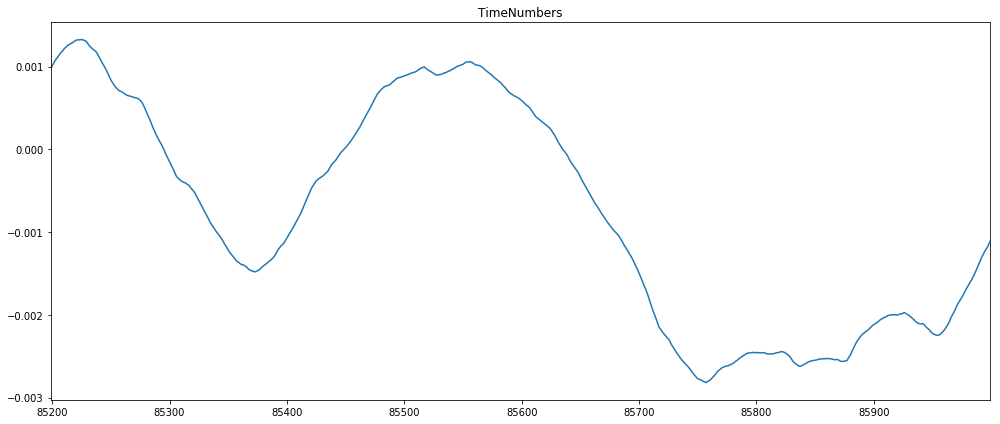

In [3]:
import matplotlib.dates as mpl_dates
from statsmodels.regression.rolling import RollingOLS
#testdata["Slope"] = testdata[["Close", "Datetime"]].rolling(20).apply(RegressionCoeff)
#testdata["Slope"] = testdata[["Close", "Datetime"]].rolling(20).apply(lambda x: RegressionCoeff(x['Close'], x['Datetime']))
testdata['TimeNumbers'] = testdata['Datetime'].apply(mpl_dates.date2num)
#testdata.iloc[:5, 1]
#print(testdata[["Close", "TimeNumbers"]].rolling(20).apply(testfn))
model = RollingOLS.from_formula("Close ~ TimeNumbers", data = testdata, window= 200)
results = model.fit(params_only=True)
print(results.params.tail(10))
# Geeting the correct slope now, so can start classifying the trend now.
fig = results.plot_recursive_coefficient(variables=['TimeNumbers'], figsize=(14,6))
#print(testdata[['TimeNumbers']].tail())

In [13]:
# we have coeffs now to classify the trend.
testdata["TrendCoeffs"] = results.params["TimeNumbers"]
#print(results.params["TimeNumbers"].tail(10))
# the trend is based on thr rolling average of the sign of coeffs
testdata["TrendDir"] = np.sign(testdata["TrendCoeffs"].rolling(20).mean())

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [20]:
# workings
testy = testdata[["Open","High", "Low","Close"]].values
flat_list = [item for sublist in testy for item in sublist]

from series2gaf import *
random_series = np.random.uniform(low=50.0, high=150.0, size=(200,))

timeSeries = list(random_series)
window_size = 100 #5
rolling_length = 50 #2
fileName = 'demo_%02d_%02d' % (windowSize, rollingLength)
# gan_rand is made  up of 10 elements (lists, which are image windows), within that is a further 50 elements (np.array) and in each of those arrays we have a further 50 numbers (whihc are the params for each image window).
# when using win = 5 and rolling = 2, then gan rand was 95 elements, with 5 further elements (np.array) and then another 5 inside.
# th enormalise window scaling of 2 doubles up the window length.
# now we get a file named demo_50_10_gaf.pkl in current directory. inside the pickle file, you got a grammian angular field with shape (15, 50, 50).

# shape[0] refers to data amount : floor((len(timeSeries)-(normalize_window_scaling-1)*windowSize)/windowSize)
# shape[1] refers to image width : sliding windowSize of the picture to make into a GAF
# shape[2] refers to image height : wthe number of steps to move forward before runnign another GAF, i.e. overlapping?
gan_rand = GenerateGAF(all_ts=testy,
            window_size=window_size,
            rolling_length=rolling_length,
            fname=fileName,
            normalize_window_scaling=1.0)

ts_img = np.load('%s_gaf.pkl' % fileName)
PlotHeatmap(ts_img)

Generating...:   0%|          | 0/18 [00:00<?, ?it/s]

Generating...: 100%|##########| 18/18 [00:00<00:00, 295.73it/s]

Output Heatmaps...:   0%|          | 0/18 [00:00<?, ?it/s]

Output Heatmaps...:   6%|5         | 1/18 [00:00<00:03,  5.48it/s]

Output Heatmaps...:  11%|#1        | 2/18 [00:00<00:02,  5.53it/s]

Output Heatmaps...:  17%|#6        | 3/18 [00:00<00:02,  5.33it/s]

Output Heatmaps...:  22%|##2       | 4/18 [00:00<00:02,  5.30it/s]

Output Heatmaps...:  28%|##7       | 5/18 [00:00<00:02,  5.32it/s]

Output Heatmaps...:  33%|###3      | 6/18 [00:01<00:02,  5.37it/s]

Output Heatmaps...:  39%|###8      | 7/18 [00:01<00:01,  5.50it/s]

Output Heatmaps...:  44%|####4     | 8/18 [00:01<00:01,  5.89it/s]

Output Heatmaps...:  50%|#####     | 9/18 [00:01<00:01,  6.02it/s]

Output Heatmaps...:  56%|#####5    | 10/18 [00:01<00:01,  6.31it/s]

Output Heatmaps...:  61%|######1   | 11/18 [00:01<00:01,  6.40it/s]

Output Heatmaps...:  67%|######6   | 12/18 [00:02<00:00,  6.47it/s]

Output Heatmaps...:  72%|#######2  | 13/18 [00:02<00:00,  6.68it/s]

Output Heatmaps...:  78%|#######7  | 14/18 [00:02<00:00,  6.79it/s]

Output Heatmaps...:  83%|########3 | 15/18 [00:02<00:00,  6.75it/s]

Output Heatmaps...:  89%|########8 | 16/18 [00:02<00:00,  6.83it/s]

Output Heatmaps...:  94%|#########4| 17/18 [00:02<00:00,  6.84it/s]

Output Heatmaps...: 100%|##########| 18/18 [00:02<00:00,  6.95it/s]

Output Heatmaps...: 100%|##########| 18/18 [00:02<00:00,  6.21it/s]

In [ ]:
# stage 2, input the GAF data to the CNN data.
# https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342
# Le Net tensor flow implementation --> https://colab.research.google.com/drive/1kV3Jpxzup63GfJB1FGKxTSKd6Ek8J3sA
# Le Net Keras implementation --> https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

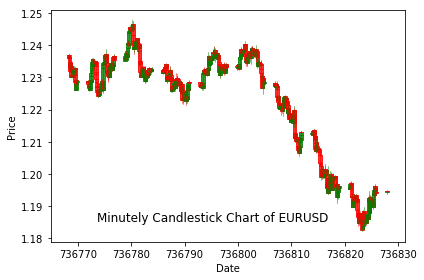

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from matplotlib.finance import candlestick_ohlc
testdata = EURUSD[85000:86000]
ohlc = testdata[["Datetime","Open","High", "Low","Close"]]
# apply datetime to all py_ timestamp objects (pd.to_datetime makes a timestamp object
#ohlc["TrueDt"] = ohlc["Datetime"].map(lambda ts: ts.to_pydatetime())
#ohlc["Datetime"] = ohlc["Datetime"].dt.to_pydatetime()
ohlc['Datetime'] = ohlc['Datetime'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

#candlestick_ohlc(ax, opens = ohlc["Open"].values,highs = ohlc["High"].values, lows = ohlc["Low"].values,closes = ohlc["Close"].values, width=0.6, colorup='green', colordown='red', alpha=0.8)
candlestick_ohlc(ax,ohlc.values , width=0.7, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Minutely Candlestick Chart of EURUSD', y = 0.25)

# Formatting Date
#date_format = mpl_dates.DateFormatter('%d-%m-%Y %')
#ax.xaxis.set_major_formatter(date_format)
#fig.autofmt_xdate()

fig.tight_layout()

plt.show()

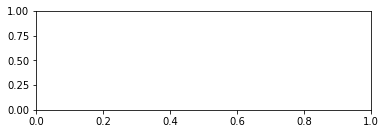

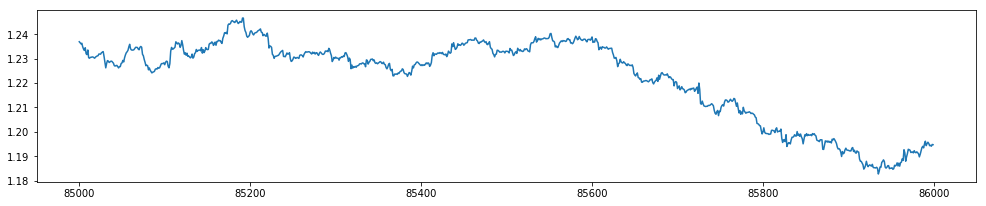

In [38]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
results.plot_recursive_coefficient(variables=['TimeNumbers'], figsize=(14,6))
plt.subplot(2, 1, 2)
plt.plot(testdata["Close"])

In [ ]:
# XXX: next steps
# train the cnn to input the image vectors and the classification of that image. (how do I know what the image classfication should be?
# to start set up a dummy classification so that the pipeline of the CNN actually works to completion.
# load the images from pickle, create the layerd CNN to accept those coefficients